In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from pprint import pprint
import pickle

In [13]:
from wordcloud import WordCloud # using the WordCloud master version from git
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english')) | set(['also', 'even', 'etc', 'either'])

# If we already have the file, go to <a href="#after_merge">this cell</a>

### Setup the category -> product

In [128]:
with open("data/productcategories.pickle", "rb") as f:
    all_cats = pickle.load(f)

Why are there double lists ? Let's inspect:

In [8]:
max_len = 0
prod_id = ''
for (prod, cats) in all_cats.items():
    if len(cats) > max_len:
        max_len = len(cats)
        prod_id = prod
pprint(all_cats[prod_id])

[['sports & outdoors', 'accessories', 'sport watches'],
 ['clothing, shoes & jewelry', 'new arrivals'],
 ['clothing, shoes & jewelry', 'jewelry: international shipping available'],
 ['clothing, shoes & jewelry', 'luxury watches'],
 ['clothing, shoes & jewelry', 'available for international shipping'],
 ['clothing, shoes & jewelry', 't', 'tag heuer'],
 ['clothing, shoes & jewelry', 'sport watches'],
 ['clothing, shoes & jewelry', 'women', 'watches', 'wrist watches'],
 ['clothing, shoes & jewelry', 'men'],
 ['clothing, shoes & jewelry', "women's athletic watches"],
 ['clothing, shoes & jewelry', "men's athletic watches"],
 ['clothing, shoes & jewelry', "women's luxury brands"]]


Reduce the category data to have just the main ones, in a simple list. Also removes duplicates

In [130]:
prods_cats = []
for prod, trees in all_cats.items():
    outer_cats = set()
    for cat_tree in trees:
        outer_cats.add(cat_tree[0])
    for cat in outer_cats:
        prods_cats.append((prod.upper(), cat))

In [131]:
categories = pd.DataFrame(prods_cats, columns=['asin', 'Category']).set_index('Category')
categories.head()

,asin
Category,
"clothing, shoes & jewelry",B0085739ZI
automotive,B006YW7F9M
tools & home improvement,B002UO6NNC
beauty,B0000BV14G
tools & home improvement,B001M4KSUK


In [135]:
categories.index.unique()

array(['clothing, shoes & jewelry', 'automotive',
       'tools & home improvement', 'beauty', 'electronics',
       'sports & outdoors', 'patio, lawn & garden',
       'health & personal care', 'home & kitchen', 'pet supplies',
       'musical instruments', 'amazon fashion', 'grocery & gourmet food',
       'video games', 'arts, crafts & sewing', 'cell phones & accessories',
       'office products', 'baby', 'toys & games',
       'industrial & scientific', 'baby products', 'movies & tv',
       'kitchen & dining', 'all electronics', 'home improvement',
       'computers', 'office & school supplies', 'cds & vinyl',
       'collectibles & fine art', 'all beauty', 'appliances'], dtype=object)

### Setup review -> product

In [47]:
revs_arr = []
with open('data/swiss_reviews.txt') as f:
    for entry in f:
        revs_arr.append(eval(entry))

In [96]:
revs = pd.DataFrame(revs_arr).set_index('asin')
revs.head(3)

,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
asin,,,,,,,,
B003U8ENTI,"[0, 0]",5.0,"Perfect fit, charged well, worked first time, ...","05 4, 2013",A00027081JC8NE8X6TD5,Kevin Corse,Well done and affordable,1367625600
B004JW1B8A,"[0, 0]",1.0,I really thought it would be a nice tote bage....,"12 3, 2012",A00090122PEQW7864EC8L,Barbara Evans,Justin Bieber Tote Bag,1354492800
B000I7GST2,"[1, 1]",5.0,"i like it so much, i hope Kuhn Rikon is availa...","07 2, 2013",A0009686KROLKEH2EHF4,shahrizal abdullah,Very stylish and practical to use,1372723200


In [100]:
revs['reviewTime'] = pd.to_datetime(revs.unixReviewTime, unit='s')
revs.drop('unixReviewTime', axis=1, inplace=True)
revs.head(3)

,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary
asin,,,,,,,
B003U8ENTI,"[0, 0]",5.0,"Perfect fit, charged well, worked first time, ...",2013-05-04,A00027081JC8NE8X6TD5,Kevin Corse,Well done and affordable
B004JW1B8A,"[0, 0]",1.0,I really thought it would be a nice tote bage....,2012-12-03,A00090122PEQW7864EC8L,Barbara Evans,Justin Bieber Tote Bag
B000I7GST2,"[1, 1]",5.0,"i like it so much, i hope Kuhn Rikon is availa...",2013-07-02,A0009686KROLKEH2EHF4,shahrizal abdullah,Very stylish and practical to use


In [101]:
print(len(revs.index.unique()))
print(len(categories.asin.unique()))

10002
10002


In [102]:
revs_cats = pd.merge(revs, categories, right_on='asin', left_index=True)
revs_cats.head()

,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,asin
Category,,,,,,,,
electronics,"[0, 0]",5.0,"Perfect fit, charged well, worked first time, ...",2013-05-04,A00027081JC8NE8X6TD5,Kevin Corse,Well done and affordable,B003U8ENTI
electronics,"[0, 0]",3.0,I have not received this product yet. Will let...,2012-11-20,A033343523Z8KJ4WKGUBJ,David W. Brown,Battery review,B003U8ENTI
electronics,"[1, 1]",1.0,The battery dies 45 days after purchase. Amazo...,2014-06-08,A10YQAG3J313HS,J. Bernard,Battery died within 45 days.,B003U8ENTI
electronics,"[0, 0]",5.0,"When it's too late to buy OEM batteries, this ...",2013-05-10,A11DS1II7Z6R3H,Mark Twain,Great replacement battery,B003U8ENTI
electronics,"[0, 0]",5.0,This product met all my expectations and it ar...,2014-07-11,A11OZBD3TCQGUF,"J. Gesink ""SHD""",Five Stars,B003U8ENTI


In [104]:
revs_cats.to_csv('data/revs_with_categories.csv')

## If we came from start of Notebook, just load from file <a id="after_merge">

In [4]:
try: revs_cats
except NameError:
    revs_cats = pd.read_csv('data/revs_with_categories.csv', index_col=0, parse_dates=['reviewTime'])

We need to do some cleaning, as there are duplicates and empty reviews (which we can ignore for wordclouds)

In [5]:
print(sum(revs_cats.duplicated(subset='reviewText')))
revs_cats.drop_duplicates(subset='reviewText', inplace=True)

48114


In [6]:
print(revs_cats.reviewText.isnull().sum()) # the duplicate removal also took 'nan' out, but not 'NaN'
revs_cats.dropna(axis='index', subset=['reviewText'], inplace=True)

1


In [28]:
revs_groups = revs_cats.groupby(level=0)
print(len(revs_groups))
print(revs_groups.groups.keys())

31
dict_keys(['grocery & gourmet food', 'arts, crafts & sewing', 'tools & home improvement', 'amazon fashion', 'clothing, shoes & jewelry', 'health & personal care', 'kitchen & dining', 'movies & tv', 'video games', 'home improvement', 'toys & games', 'sports & outdoors', 'cell phones & accessories', 'patio, lawn & garden', 'office & school supplies', 'musical instruments', 'all electronics', 'baby', 'all beauty', 'computers', 'baby products', 'office products', 'pet supplies', 'appliances', 'beauty', 'home & kitchen', 'automotive', 'industrial & scientific', 'electronics', 'cds & vinyl', 'collectibles & fine art'])


In [9]:
def show_img(img):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img)

In [10]:
electro_df = revs_groups.get_group('electronics')

In [10]:
electro_list = electro_df.reviewText.tolist()

electro_corpus = '\n'.join(electro_list)
len(electro_corpus)

In [11]:
electro_wc = WordCloud(height=400, max_words=1600, scale=3, collocations=True, background_color='white', 
                       stopwords=stopwords)

In [23]:
electro_img = electro_wc.generate(electro_corpus)

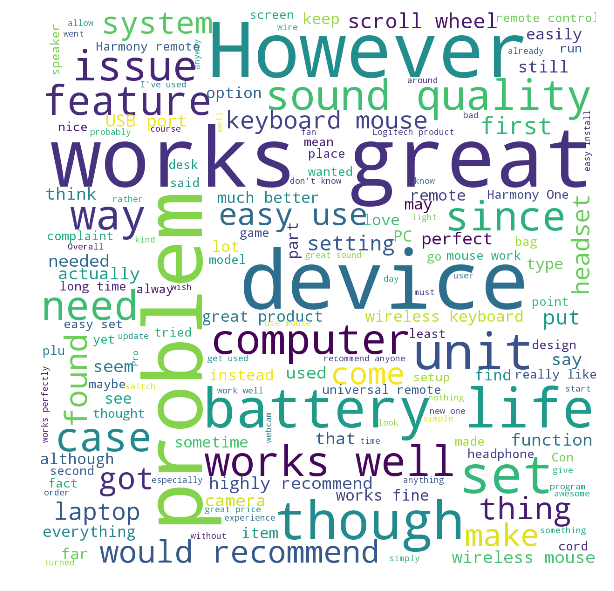

In [24]:
show_img(electro_img)

In [7]:
def process_cat(cat_df, wc):
    import operator
    import time
    # TODO: tune relative_scaling, max_words
    t = time.time()
    
    idx_pos = cat_df.overall > 3
    idx_neg = cat_df.overall < 3
    pos_corpus = cat_df[idx_pos].reviewText.str.cat(sep='\n')
    neg_corpus = cat_df[idx_neg].reviewText.str.cat(sep='\n')
    print("Corpora done", time.time() - t, flush=True)

    t = time.time()
    # we want to get the different frequencies for pos / neg
    pos_words = wc.process_text(pos_corpus)
    neg_words = wc.process_text(neg_corpus)
    print("Processing done", time.time() - t, flush=True)

    # filter out the non-interesting ones; wc.process_text should be doing this already :|
    pos_words = sorted(pos_words.items(), key=operator.itemgetter(1), reverse=True)[:wc.max_words]
    neg_words = sorted(neg_words.items(), key=operator.itemgetter(1), reverse=True)[:wc.max_words]
    
    pos_df = pd.DataFrame.from_records(pos_words, columns=['word', 'pos'], index='word')
    neg_df = pd.DataFrame.from_records(neg_words, columns=['word', 'neg'], index='word')
    
    freq_df = pd.merge(pos_df, neg_df, how='outer', left_index=True, right_index=True)\
                .fillna(0)
    freq_df['total'] = freq_df.pos + freq_df.neg
    return freq_df, idx_pos.sum(), idx_neg.sum()

In [13]:
electro_freq, num_pos, num_neg = process_cat(electro_df)

Corpora done 0.0929880142211914
Processing done 51.90972542762756
Filtering done 0.19684076309204102
Creating done 0.002852916717529297
Merging done 0.0028977394104003906


In [8]:
def score_word(pos, neg, total_pos, total_neg, normalized=True):
    """ Gives the magnitute of the 'feeling' based on numbers.
        If normalized, returns in [0,1]. Otherwise, in [-1, 1]
        Note: can underflow if very big `total`
    """
    if pos == 0 and neg == 0:
        ratio = 0
    else:
        # scale to account for class imbalance
        pos, neg = pos/total_pos, neg/total_neg
        ratio = (pos - neg) / (pos + neg) # [-1, 1]
    if normalized:
        return (ratio + 1) / 2            # [0, 1]
    else:
        return ratio

In [9]:
def get_brewer_color_func(freq_df, total_pos, total_neg):
    """ Returns a coloring function which takes into account the word pos/neg frequencies scaled
    by the number of pos/neg reviews.
    Uses colorbrewer with 11 classes: red -> yellow -> green.
    
    Parameters:
    -----------
        freq_df: a pd.DataFrame created with `process_cat` function; 
            Needs to have (pos, neg, ...) columns"""
    
    diverging_scheme = [ # red - yellow - green : http://colorbrewer2.org/#type=diverging&scheme=RdYlGn&n=11
      (165,0,38), (215,48,39), (244,109,67), (253,174,97), (254,224,139), (255,255,191), (217,239,139),
      (166,217,106), (102,189,99), (26,152,80), (0,104,55),
    ]
    max_idx = len(diverging_scheme) - 1

    def word_color_mapper(word, font_size, position, orientation, font_path=None, random_state=None):
        pos, neg = freq_df.at[word, 'pos'], freq_df.at[word, 'neg']
        score = score_word(pos, neg, total_pos, total_neg)
        color_idx = int(score * max_idx)
#         print(pos, neg, color_idx)
        assert(color_idx >= 0 and color_idx < len(diverging_scheme))
        return 'rgb({:.0f}, {:.0f}, {:.0f})'.format(*diverging_scheme[color_idx])

    return word_color_mapper
    

In [10]:
def get_cmap_color_func(freq_df, total_pos, total_neg, colormap):
    """ Returns a coloring function which takes into account the word pos/neg frequencies scaled
    by the number of pos/neg reviews.
    Uses matlab colormap from param
    
    Parameters:
    -----------
        freq_df: a pd.DataFrame created with `process_cat` function; 
            Needs to have (pos, neg, ...) columns"""
    import matplotlib.pyplot as plt
    colormap = plt.cm.get_cmap(colormap)

    def word_color_mapper(word, font_size, position, orientation, font_path=None, random_state=None):
        pos, neg = freq_df.at[word, 'pos'], freq_df.at[word, 'neg']
        score = score_word(pos, neg, total_pos, total_neg)
        r,g,b,a = colormap(score, bytes=True)
        return 'rgb({},{},{})'.format(r,g,b)

    return word_color_mapper
    

In [46]:
electro_wc.scale = 1
electro_wc.width = 800
electro_wc.height = 800
electro_wc.min_font_size = 2
electro_wc.relative_scaling = 1

electro_wc.fit_words(electro_freq.total.to_dict())

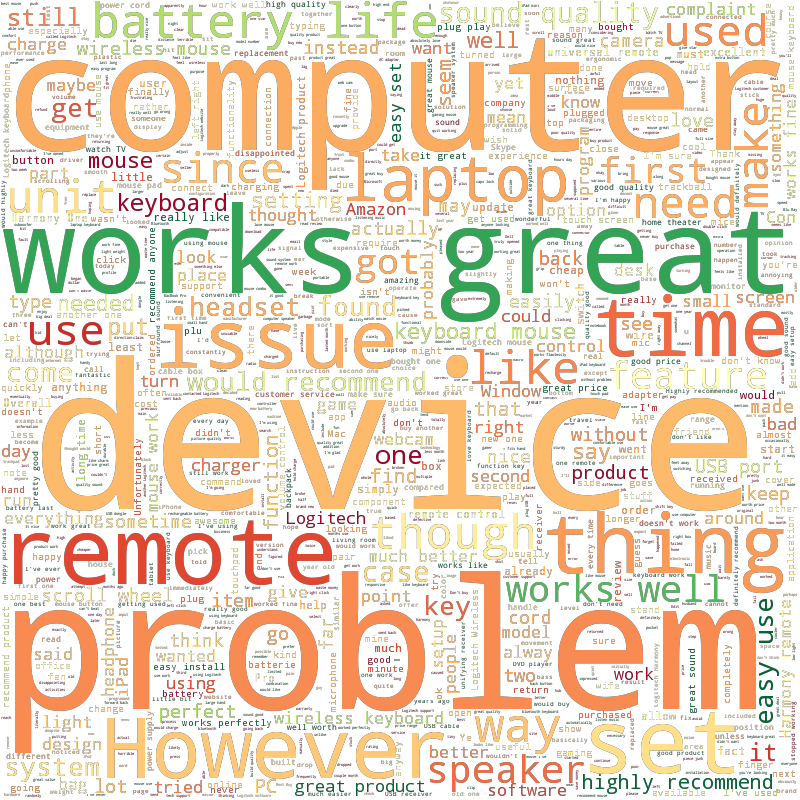

In [71]:
# electro_wc.color_func = get_brewer_color_func(electro_freq, num_pos, num_neg)
electro_wc.mode = "RGB"
electro_wc.background_color = "#121212"
electro_wc.color_func = get_cmap_color_func(electro_freq, num_pos, num_neg, 'RdYlGn')
electro_wc.recolor()
electro_wc.to_image()

# electro_wc.recolor()
electro_wc.to_image()

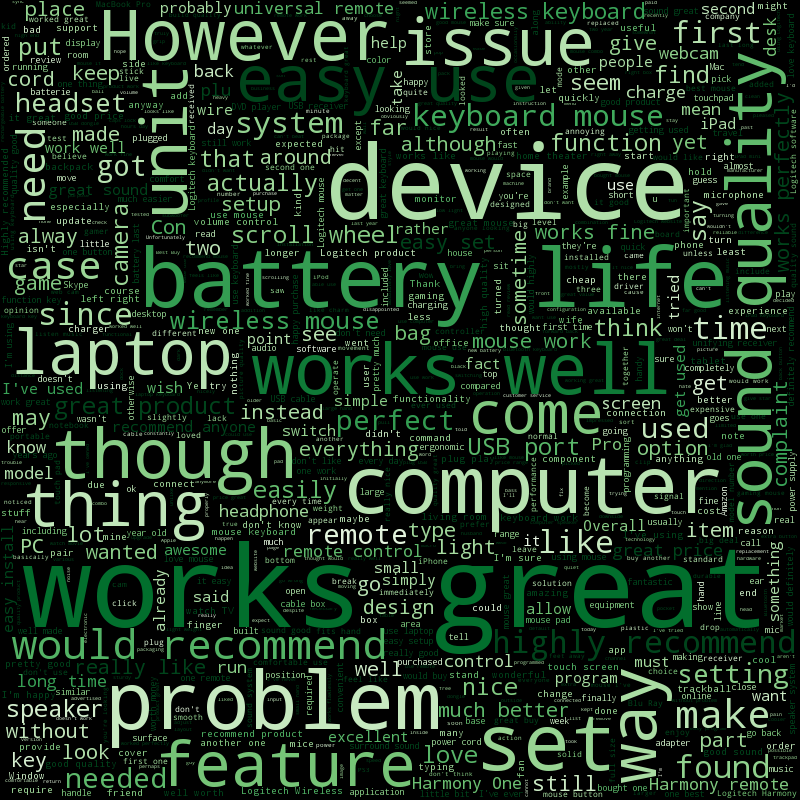

In [83]:
pos_wc = WordCloud(height=800, width=800, max_words=1600, scale=1, collocations=True, relative_scaling=1,
                   stopwords=stopwords)
pos_wc.color_func = get_cmap_color_func(electro_freq, num_pos, num_neg, 'Greens')
pos_wc.fit_words(electro_freq.pos.to_dict())
pos_wc.to_image()

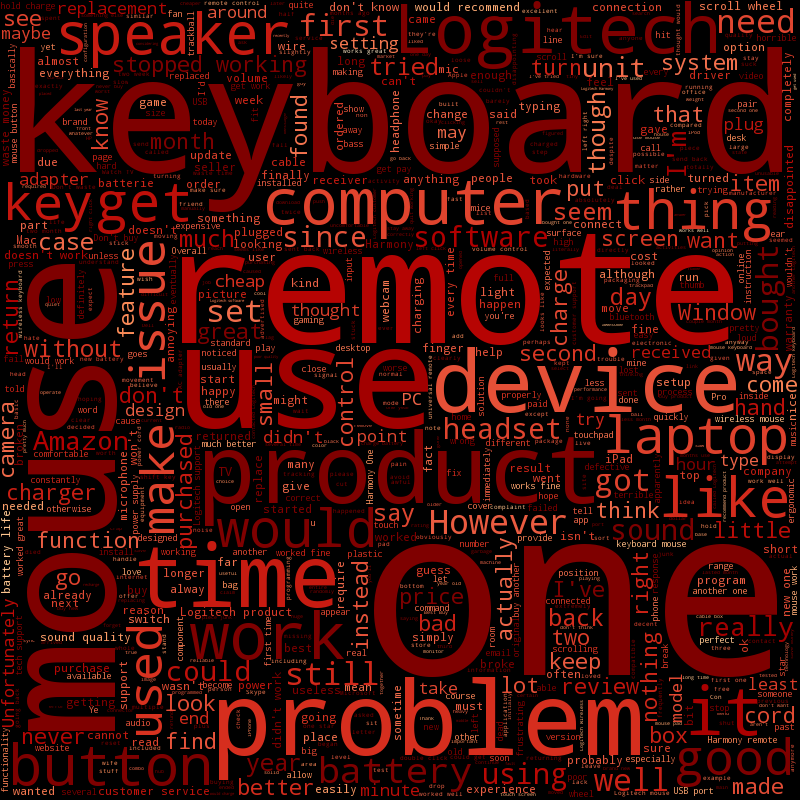

In [87]:
neg_wc = WordCloud(height=800, width=800, max_words=1600, scale=1, collocations=True, relative_scaling=1,
                   stopwords=stopwords)
neg_wc.color_func = get_cmap_color_func(electro_freq, num_pos, num_neg, 'OrRd_r')
neg_wc.fit_words(electro_freq.neg.to_dict())
neg_wc.to_image()

In [ ]:
dr.rectangle()

In [88]:
def add_legend(img, cmap_name):
    """ Adds a legend with the given colormap name"""
    from PIL import Image, ImageDraw, ImageFont
    import matplotlib.pyplot as plt
    
    orig_h, orig_w = img.size
    # add canvas size, 20% to the right
    new_img = img.crop((0,0, orig_w + 0.2*orig_w, orig_h))
    new_img.load() # force cropping NOW!
    
    # after 'cropping' 
    draw = ImageDraw.Draw(new_img)
    draw.rectangle(((orig_w,0), (new_img.width,new_img.height)), fill='#FFF')
    
    # get an image of the legend of 80% height
    legend_h = int(0.8 * orig_h)
    legend_w = int(0.1 * orig_w)
    legend_arry = plt.get_cmap(cmap_name)(np.linspace(0,1,legend_h).repeat(legend_w).reshape(legend_h,legend_w), bytes=True)
    legend_img = Image.fromarray(legend_arry) # the name is actually legend___wait_for_it___arry
    
    # the legend is centred in the extra space we created. check it ! :)
    leg_offset = (int(orig_w + 0.05*orig_w), int(0 + 0.1*orig_h))
    new_img.paste(legend_img, leg_offset)
    
    # add some text around the legend
    font = ImageFont.truetype('DroidSansMono.ttf', 22)
    
    # draw text at upper bound; you can use `tuple(legend_arry[0,0,:3])` as color
    text_offset = (leg_offset[0], leg_offset[1] - 25 * 2) # 2 lines
    draw.text(text_offset, "Mostly\nnegative", (255,255,255), font=font)
    
    text_offset = (leg_offset[0], leg_offset[1] + legend_h + 6)
    draw.text(text_offset, "Mostly\npositive", (255,255,255), font=font)
    
    return new_img

In [76]:
def get_cloud_fitter(cat_name, cat_df, wc, check_exists=True):
    """ Gives you a function to call on pos, neg, total"""
    from os import path
    from glob import glob
    from scipy.misc import imread
    from PIL import Image

    num_existing_files = len(glob(path.join('clouds', cat_name+'*.png')))
    if num_existing_files == 3:
        print('Skipping {} altogether'.format(cat_name), flush=True)
        return lambda *args: None

    mask_path, mask = path.join("masks", cat_name + ".png"), None
    if path.isfile(mask_path):
        mask = imread(mask_path)
        # use the part with more space as the mask
#         if mask.sum() > np.invert(mask).sum(): # we have more white
#             mask = np.invert(mask)
    wc.mask = mask

    print("processing", cat_name, flush=True)
    freq_df, total_pos, total_neg = process_cat(cat_df, wc)
    
    # mapping from type to colormap
    cmaps = {'pos' : 'Greens', 'neg' : 'OrRd_r', 'total':'RdYlGn'}
    
    def fitter(cloud_type='total', save=True):
        """ Fits the words in the given type to the preset cloud 
            `cloud_type` = (total | pos | neg)"""
        # sanity check
        assert(cloud_type in cmaps.keys())
        
        # skip if it exists
        img_name = path.join('clouds', '{}_{}.png'.format(cat_name, cloud_type))
        if check_exists and path.isfile(img_name):
            print('Skipping', img_name)
            return
    
        # tune color_func for this type and generate
        wc.color_func = get_cmap_color_func(freq_df, total_pos, total_neg, cmaps[cloud_type])
        wc.fit_words(freq_df[cloud_type].to_dict())
        img = wc.to_image()
        
        # remove the extraneous black-ish background, but only where not needed. Using mask
        if mask is not None:
            # turn it into image
            mask_img = Image.fromarray(mask[:,:,0])
            img = Image.composite(mask_img, img, mask_img)
#         img = add_legend(img, cmaps[cloud_type]) # for poster, don't add legend on each
        
        if save:
            print('Saving', img_name, flush=True)
            img.save(img_name)
            img.close()
#         return img
    
    return fitter

In [64]:
def process_group(group, save=True, check_exists=True, num_items=None):
    from os import path
    from scipy.misc import imread
    
    num_processed = 0
    
    wc = WordCloud(width=800, height=800, max_words=1600, prefer_horizontal=0.7, scale=1, stopwords=stopwords,
                    min_font_size=2, background_color="#121212", relative_scaling=1, collocations=True)
    for cat_name, cat_df in revs_groups:
        if cat_df.overall.count() < 2000:
            continue
        
        fitter = get_cloud_fitter(cat_name, cat_df, wc, check_exists)
        fitter('total', save)
        fitter('pos', save)
        fitter('neg', save)
        
        num_processed += 1
        if num_items and num_processed == num_items:
            break

In [78]:
process_group(revs_groups)

Skipping automotive altogether
Skipping baby altogether
processing beauty
Corpora done 0.00463104248046875
Processing done 1.7120256423950195
Saving clouds/beauty_total.png
Skipping clouds/beauty_pos.png
Skipping clouds/beauty_neg.png
processing clothing, shoes & jewelry
Corpora done 0.011731386184692383
Processing done 7.173766613006592
Saving clouds/clothing, shoes & jewelry_total.png
Skipping clouds/clothing, shoes & jewelry_pos.png
Skipping clouds/clothing, shoes & jewelry_neg.png
processing electronics
Corpora done 0.08158588409423828
Processing done 51.08808374404907
Saving clouds/electronics_total.png
Skipping clouds/electronics_pos.png
Skipping clouds/electronics_neg.png
Skipping grocery & gourmet food altogether
Skipping health & personal care altogether
Skipping home & kitchen altogether
Skipping office products altogether
Skipping patio, lawn & garden altogether
Skipping sports & outdoors altogether
Skipping tools & home improvement altogether
Skipping video games altogether

In [80]:
wc = WordCloud(width=800, height=800, max_words=2500, prefer_horizontal=0.7, scale=1, stopwords=stopwords,
               min_font_size=2, background_color="#121212", relative_scaling=1, collocations=True)

In [81]:
swiss_fitter= get_cloud_fitter('swiss',revs_cats,wc,)

processing swiss
Corpora done 0.1375751495361328
Processing done 85.57911992073059


In [82]:
img = swiss_fitter('total', save=True)

Saving clouds/swiss_total.png


In [83]:
swiss_fitter('pos')

Saving clouds/swiss_pos.png


In [84]:
swiss_fitter('neg')

Saving clouds/swiss_neg.png


In [89]:
img = Image.new('RGB', (800,800), color='white')
res = add_legend(img, 'RdYlGn')